# Gradient Boosting
## 1. Load packages

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from scipy.stats import uniform, loguniform, randint

## 2. Prepare data 

In [44]:
#load data
df = pd.read_csv("C:/Users/julie/supervised_project/dataframe_PS_3.csv", index_col='Unnamed: 0')


#define X and y 
X = df[[
    'temp_DE', 
    'weekday', 
    'hour', 
    'season', 
    'year',
    'Q_DE_lag1',
    'Q_AT_lag1', 
    'Q_BE_lag1', 
    'Q_FR_lag1', 
    'Q_NL_lag1'
       ]]


y = df['Q_DE']

data_dmatrix = xgb.DMatrix(data=X,label=y)

#split the dataframe betweenn train and test 
X_train = X.iloc[:round(len(df)*0.75)]
y_train = y.iloc[:round(len(df)*0.75)]
X_test = X.iloc[round(len(df)*0.75):]
y_test = y.iloc[round(len(df)*0.75):]

## 3. Hyperparameter tuning

In [ ]:
def report(results, n_top=3):
    '''https://scikit-learn.org/stable/auto_examples/model_selection/plot_randomized_search.html
    '''
    # Utility function to report best scores
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})"
                  .format(results['mean_test_score'][candidate],
                          results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")


xgb_model = xgb.XGBRegressor()

param_search = {
    'max_depth': randint(5, 20),
    'min_child_weight': uniform(1.5, 1),
    'learning_rate': loguniform(1e-4, 1e0),
    'gamma': uniform(5, 5)
}

tscv = TimeSeriesSplit(n_splits=10)

rsearch = RandomizedSearchCV(
    estimator=xgb_model,
    cv=tscv,
    param_distributions=param_search,
    verbose=True,
    n_jobs=-1
).fit(X_train, y_train)

report(rsearch.cv_results_)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


## 4. Estimation

In [45]:
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', gamma = 5.138888354891557, learning_rate = 0.08468248540052926,
                max_depth = 12, min_child_weight= 1.5227282310121135)

xg_reg.fit(X_train,y_train)

preds = xg_reg.predict(X_test)

RMSE_xgb = np.sqrt(mean_squared_error(y_test, preds))

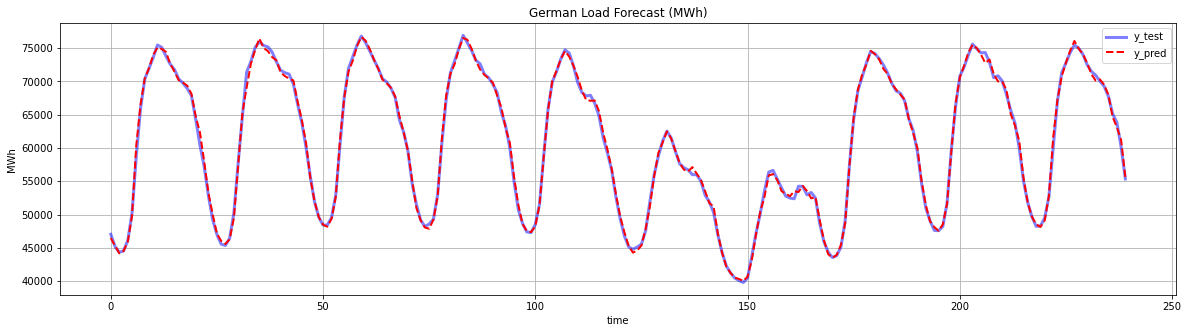

In [51]:
plt.figure(figsize=(20,5))
plt.plot(y_test.values[:240], c='b', label='y_test', lw=3, alpha=0.5)
plt.plot(preds[:240], '--', c='r', label='y_pred', lw=2)
plt.legend()
plt.grid()
plt.title('German Load Forecast (MWh)')
plt.xlabel('time')
plt.ylabel('MWh')
plt.savefig('XGBoostpred.png')

## 5. Evaluation

In [56]:
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
print("Root mean squared error is equal to:",RMSE_xgb, "MWh")
print("Mean absolute percentage error is equal to:", mean_absolute_percentage_error(y_test, preds))

Root mean squared error is equal to: 755.6214516317488 MWh
Mean absolute percentage error is equal to: 0.8341448346197785


## 6.Features importances

Text(0, 0.5, 'Feature Importance')

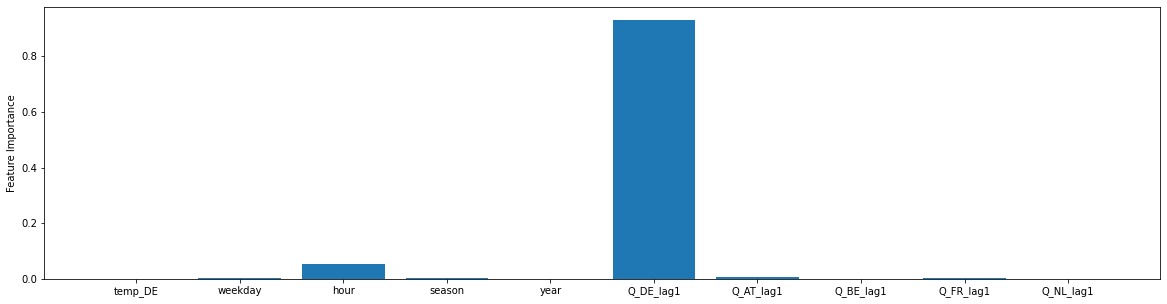

In [46]:
features_importances = xg_reg.feature_importances_

plt.figure(figsize=(20,5))
plt.bar(X.columns.to_list(),features_importances)
plt.ylabel("Feature Importance")